In [ ]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.insert(0,'/home/pawel1/Pulpit/Astrophysics/CTA/soft/ctapipe_io_lst')
sys.path.insert(0, '/home/pawel1/Pulpit/Astrophysics/CTA/cta-lstchain')

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

from ctapipe.image.extractor import LocalPeakWindowSum

from lstchain.calib.camera.r0 import LSTR0Corrections

from tools import get_first_capacitor
from time_cal_corr_all_camera import TimeCalCorr, get_mean_time, get_corr_time, extract_pulse_time,  ArrivalTimeCorr
from time_cal_corr import plot_corr_curve, make_hist
plt.rcParams['font.size'] = 15

In [2]:
n_combine = 8
n_harm = 16
n_cap = 1024
n = int(n_cap/n_combine)
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/media/pawel1/ADATA HD330/20190215/pedestal_run97_new.fits",
        "offset":  400,
        "tel_id": 0, # for EVB3 will be 
    }
})

#input_file_1 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00171.0000.fits.fz"
input_file_1 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00250.0000.fits.fz"

In [4]:
reader = LSTEventSource(input_url=input_file_1, max_events=12000)
lst_r0 = LSTR0Corrections(config=config_corr)

timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)


for i, ev in enumerate(reader):
    if ev.r0.event_id%500 == 0:
        print(ev.r0.event_id)
    lst_r0.calibrate(ev)
    timeCorr.calib_pulse_time(ev)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000


In [5]:
timeCorr.finalize()

/home/pawel1/Pulpit/Astrophysics/CTA/low_level_calib_drs4/time_corr/time_cal_corr_all_camera.py:47: RuntimeWarning: divide by zero encountered in true_divide
  self.fMeanVal = self.fMeanVal /self.fNumMean
/home/pawel1/Pulpit/Astrophysics/CTA/low_level_calib_drs4/time_corr/time_cal_corr_all_camera.py:47: RuntimeWarning: invalid value encountered in true_divide
  self.fMeanVal = self.fMeanVal /self.fNumMean


error = 0.014464917324088852


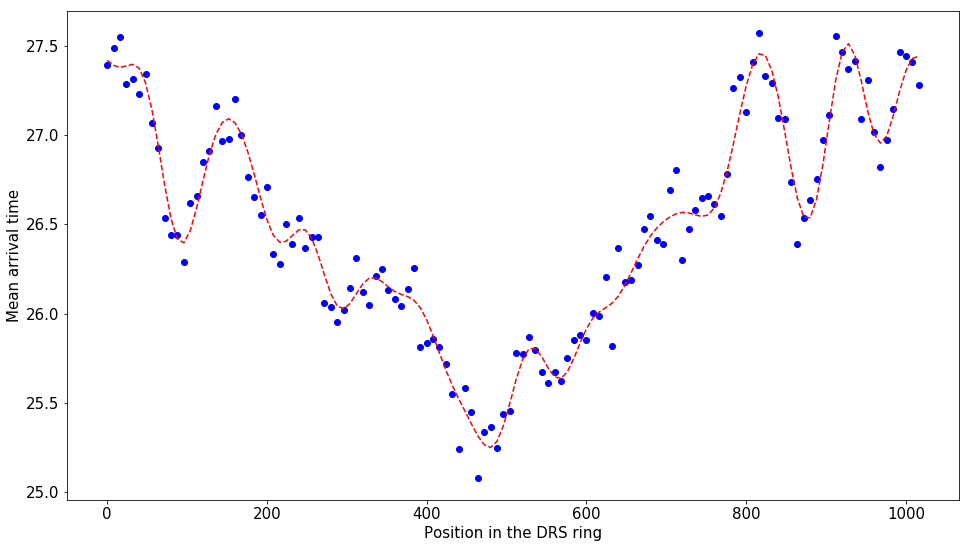

error = 0.01543271303776274


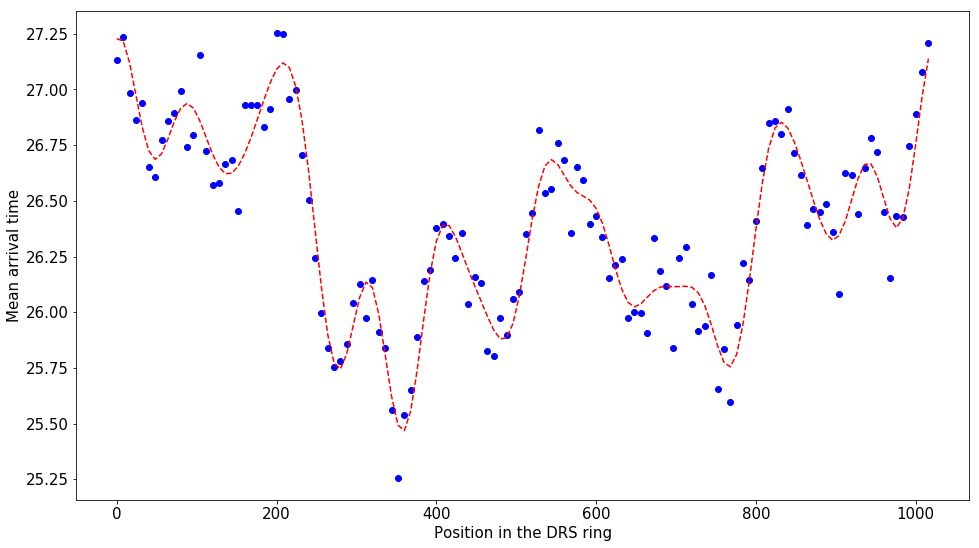

error = 0.013485790459012381


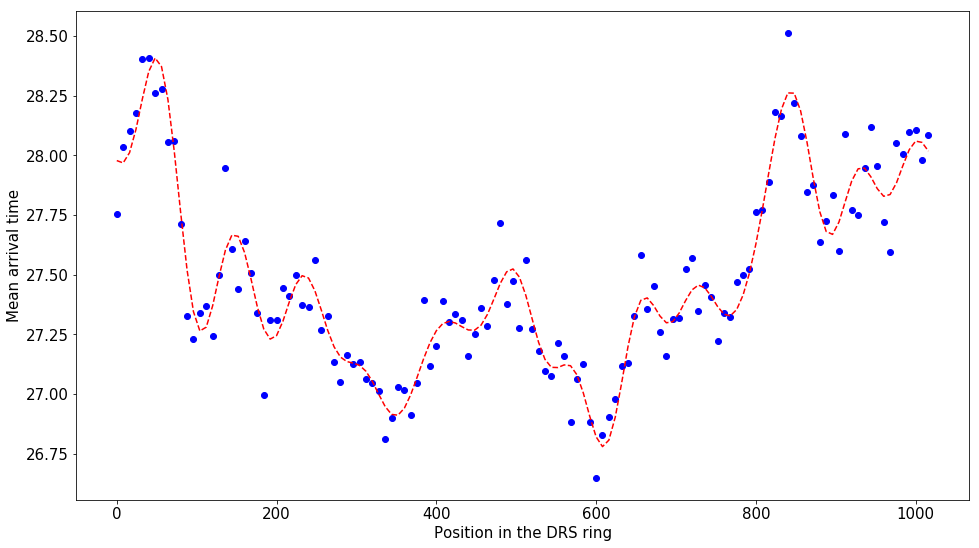

error = 0.015471557056204791


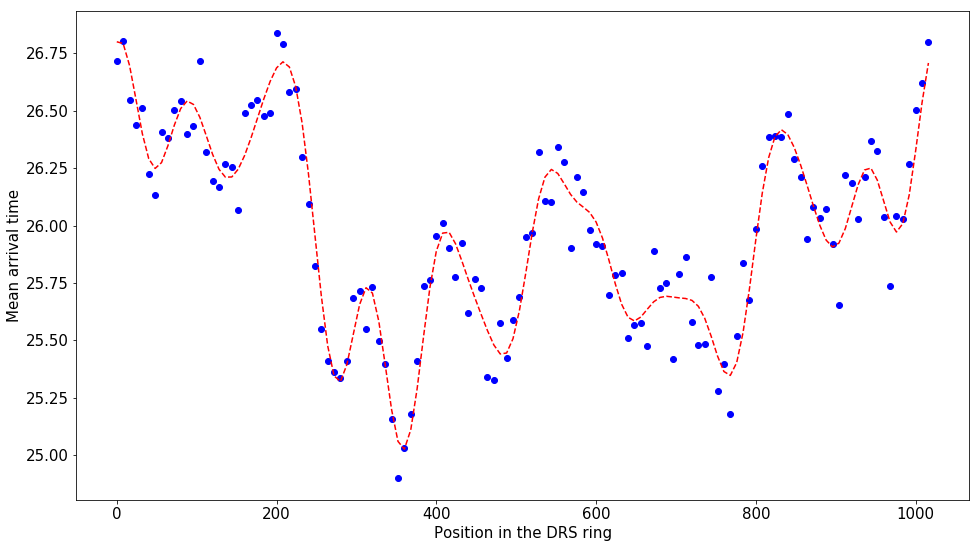

error = 0.014312303263473117


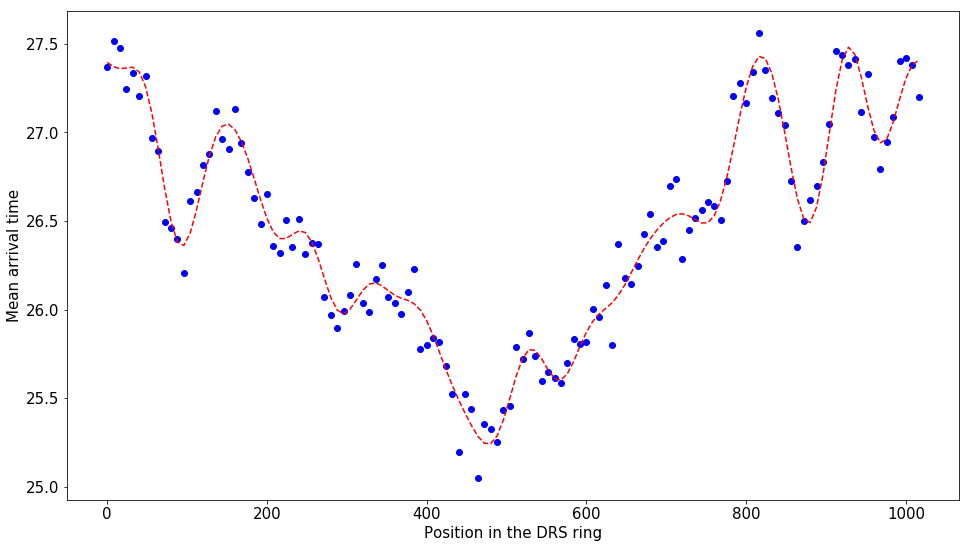

In [8]:
for pix_id in range(0, 5):
    pixel_id = pix_id
    timeCorr.fit(pix_id)
    an = timeCorr.fan
    bn = timeCorr.fbn
    fMeanVal = timeCorr.fMeanVal[pix_id]
    plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal)
    plt.show()

In [9]:
fan_array = np.zeros((1855, n_harm))
fbn_array = np.zeros((1855, n_harm))
for pix_id in range(0, 1855):
    timeCorr.fit(pix_id)
    fan_array[pix_id, :] = timeCorr.fan
    fbn_array[pix_id, :] = timeCorr.fbn

In [ ]:
def plot_corr_curve2(n, n_cap, n_combine, an, bn, fMeanVal):
    fc = np.arange(0, n_cap, n_combine)
    y = np.zeros(n)

    for i in range(0, len(y)):
        temp_cos = an[0] / 2
        temp_sin = 0
        for j in range(1, len(an)):
            temp_cos += an[j] * np.cos(2 * j * np.pi * (fc[i] / 1024.))
            temp_sin += bn[j] * np.sin(2 * j * np.pi * (fc[i] / 1024.))
        y[i] = (temp_cos + temp_sin)

    plt.plot(np.arange(0, n_cap, n_combine), fMeanVal, 'bo', markersize=4)
    plt.plot(fc, y, 'r--')
    plt.ylabel("Mean arrival time")
    plt.xlabel("Position in the DRS ring")


In [ ]:
fMeanVal = timeCorr.fMeanVal[1790]
ax1 = plot_corr_curve2(n, n_cap, n_combine, fan_array[1790], fbn_array[1790], fMeanVal)

In [ ]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_corr_curve2(n, n_cap, n_combine, fan_array[1790], fbn_array[1790], fMeanVal)

plt.subplot(1, 2, 2)
plt.hist(arrival_time_list[1790], range=(20, 35), bins=35, histtype='step', lw=2)
plt.hist(arrival_time_corr_list[1790], range=(20, 35), bins=35, histtype='step', lw=3)
    

plt.tight_layout()
plt.show()

In [ ]:
from numba import njit, prange

In [17]:
input_file_2 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00251.0000.fits.fz"
#input_file_2 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00171.0001.fits.fz"
N_events = 3000
reader = LSTEventSource(input_url=input_file_2, max_events=N_events)

lst_r0 = LSTR0Corrections(config=config_corr)
ArrTimeCorr = ArrivalTimeCorr(fan_array, fbn_array, n_harm)




for i, ev in enumerate(reader):
    if i%200 == 0:
        print(i)
    lst_r0.calibrate(ev)
    ArrTimeCorr.corr_arrivial_time(ev, N_module=265)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800


In [18]:
expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
arrival_time_list = ArrTimeCorr.get_arrivial_time_list()
arrival_time_corr_list = ArrTimeCorr.get_arrivial_time_corr_list()
std_before_corr = []
std_after_corr = []
for nr in range(0, 265):
    for pix in range(0, 7):
        pixel_id = expected_pixel_id[nr*7 + pix]
        std_arrival = np.nanstd(arrival_time_list[pixel_id])
        std_corr_arrival = np.nanstd(arrival_time_corr_list[pixel_id])
        std_before_corr.append(std_arrival)
        std_after_corr.append(std_corr_arrival)

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


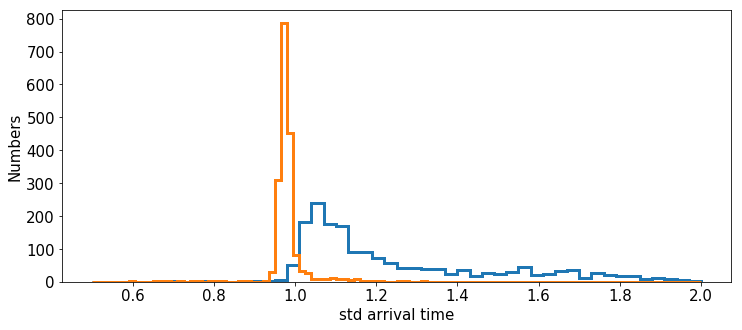

In [19]:
plt.figure(figsize=(12, 5))
plt.hist(std_before_corr, bins=50, range=(0.5, 2), histtype='step', lw=3)
plt.hist(np.nan_to_num(std_after_corr), bins=100, range=(0.5, 2), histtype='step', lw=3)
#plt.yscale('log')
plt.ylabel("Numbers")
plt.xlabel("std arrival time")
plt.show()

In [16]:
np.where(np.array(std_before_corr) == 0)

(array([222, 254, 261, 268, 275, 289, 303]),)

In [17]:
std_before_corr[222]

0.0

In [18]:
std_after_corr[222]

nan

Nr_module = 0, pix = 0
Nr pixel = 1853, std 1 = 1.12, std 2 = 0.98
error = 0.015809216243009377


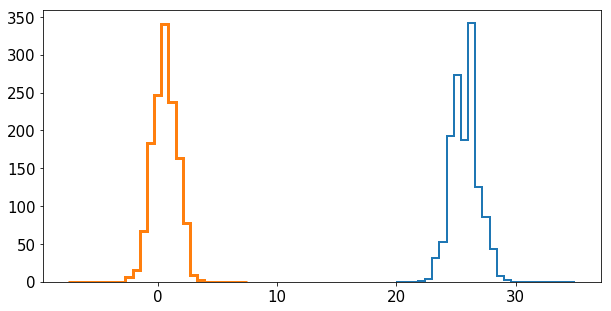

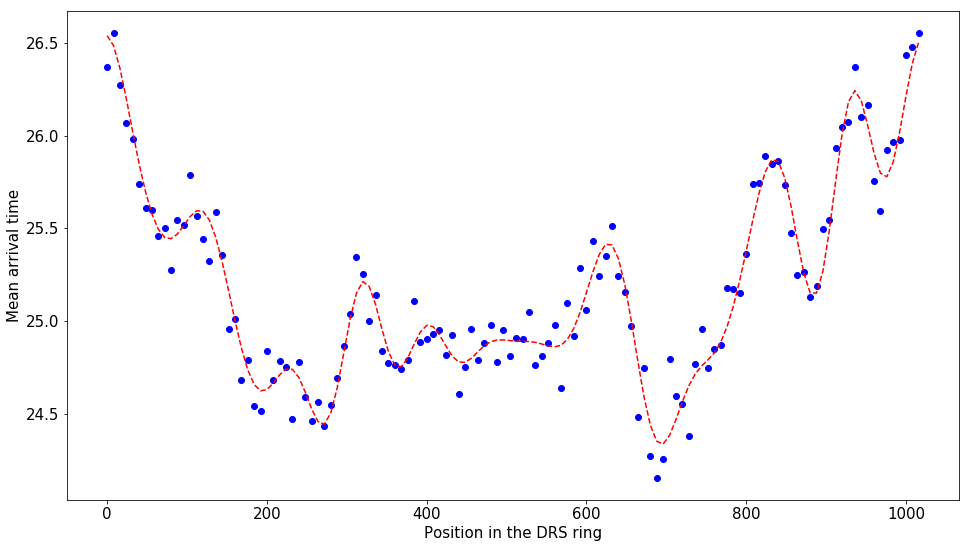

Nr_module = 0, pix = 1
Nr pixel = 1838, std 1 = 1.12, std 2 = 0.98
error = 0.01645868787003077


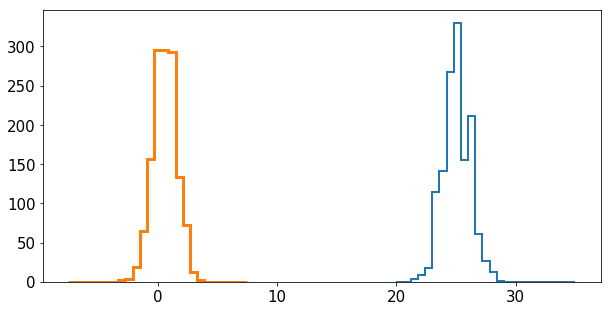

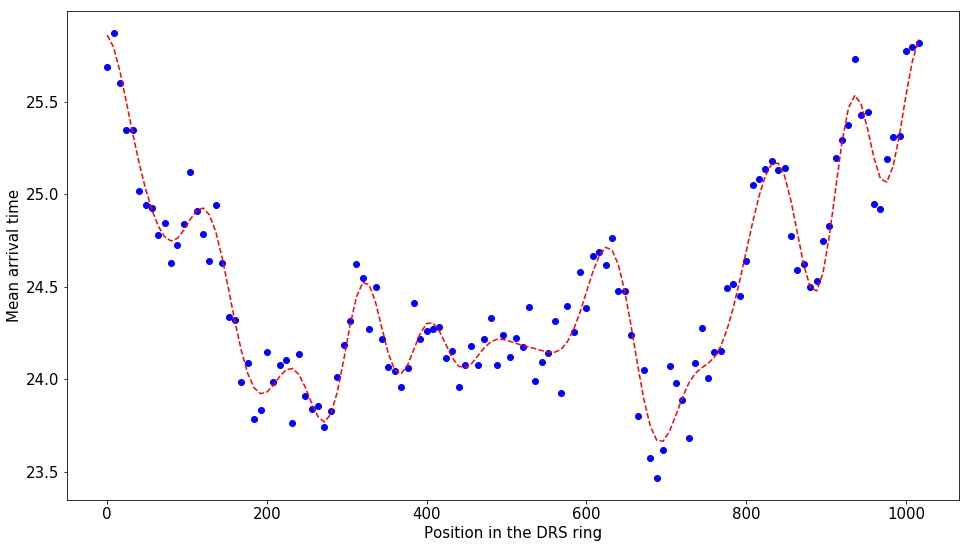

Nr_module = 0, pix = 2
Nr pixel = 1794, std 1 = 1.22, std 2 = 0.95
error = 0.01551039604658085


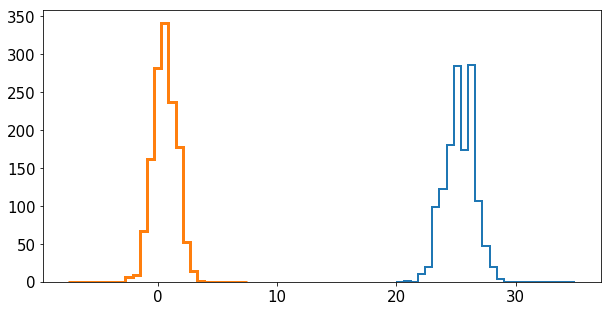

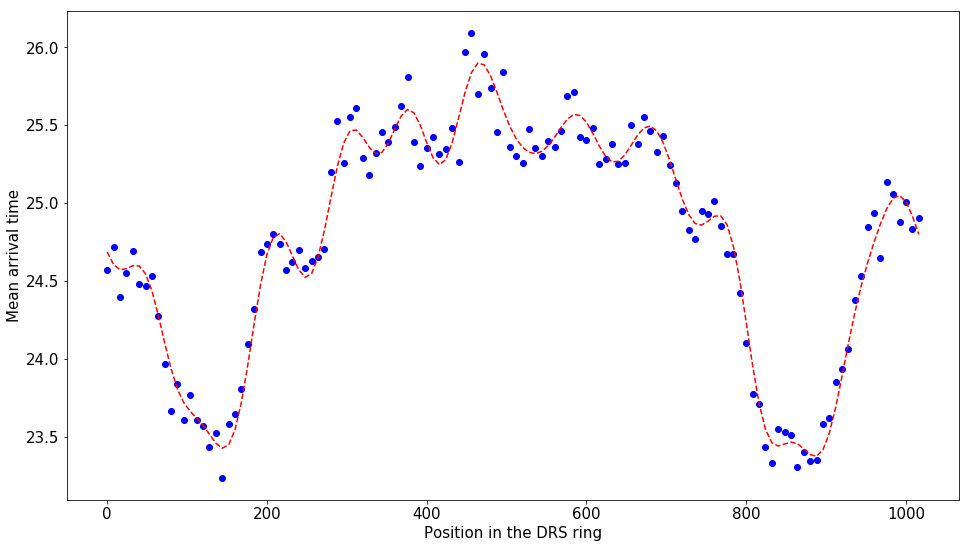

Nr_module = 0, pix = 3
Nr pixel = 1839, std 1 = 1.23, std 2 = 0.97
error = 0.01631022800436123


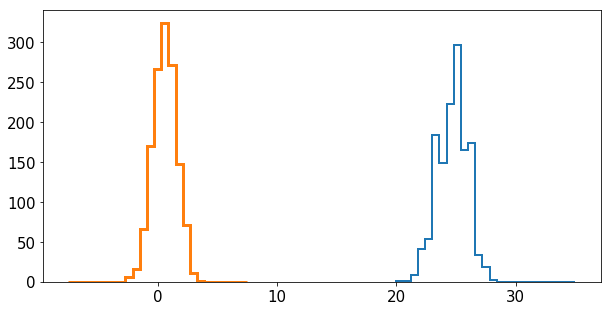

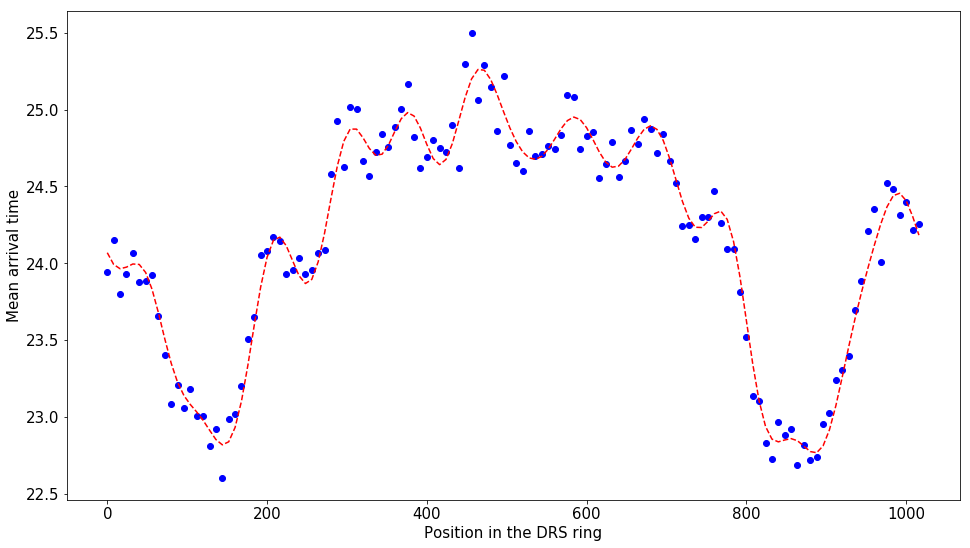

Nr_module = 0, pix = 4
Nr pixel = 1854, std 1 = 1.28, std 2 = 1.00
error = 0.016407671853501282


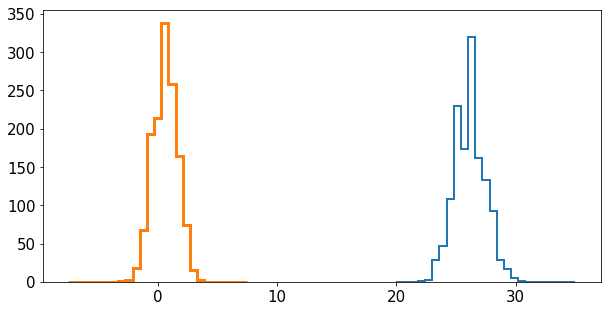

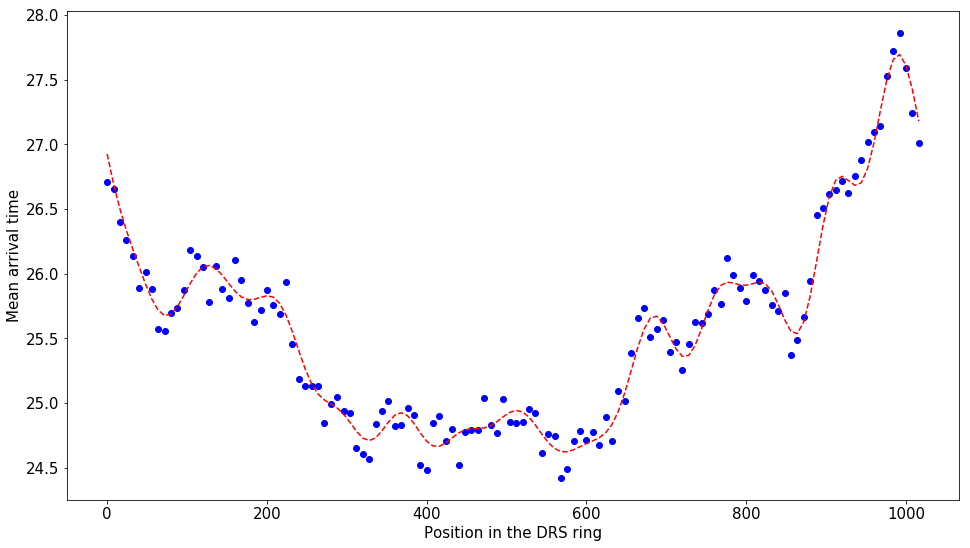

Nr_module = 0, pix = 5
Nr pixel = 1795, std 1 = 1.27, std 2 = 0.99
error = 0.016039339588048363


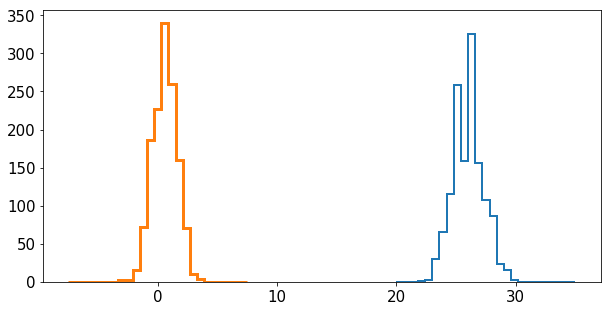

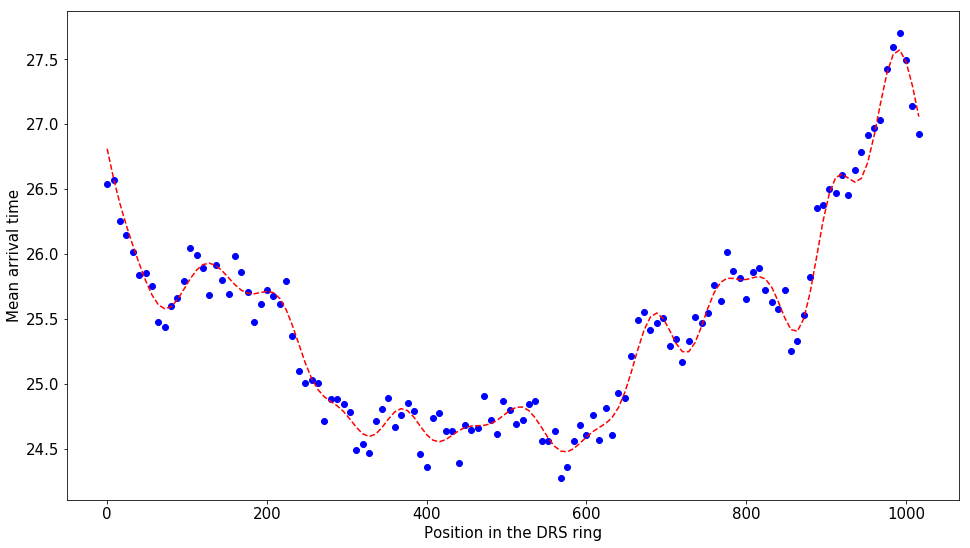

Nr_module = 0, pix = 6
Nr pixel = 1840, std 1 = 1.07, std 2 = 0.99
error = 0.016632908997252595


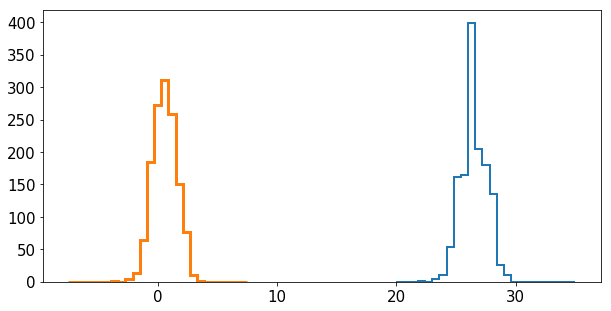

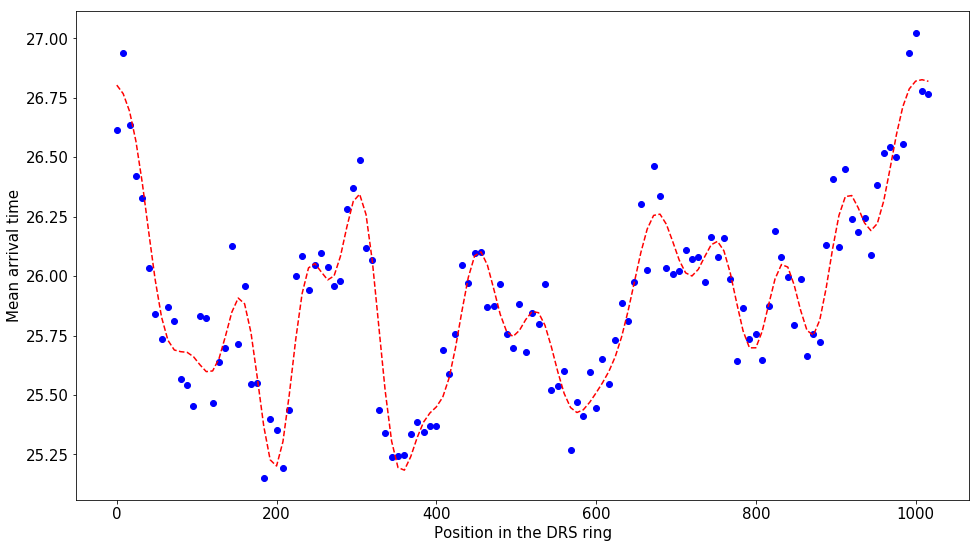

Nr_module = 1, pix = 0
Nr pixel = 1836, std 1 = 1.37, std 2 = 0.97
error = 0.014911206798478141


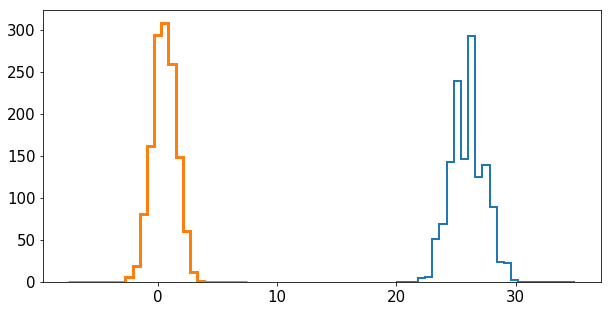

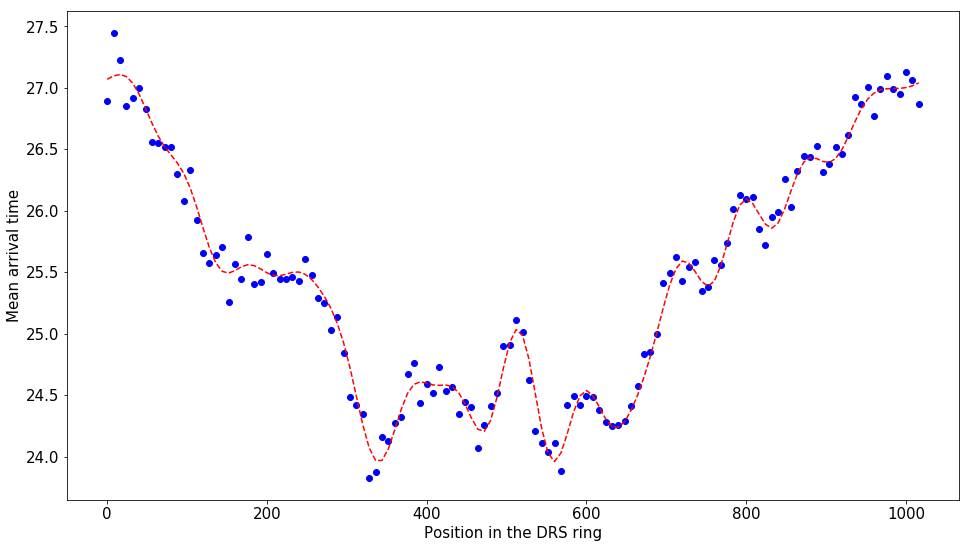

Nr_module = 1, pix = 1
Nr pixel = 1791, std 1 = 1.37, std 2 = 0.98
error = 0.014926689233956996


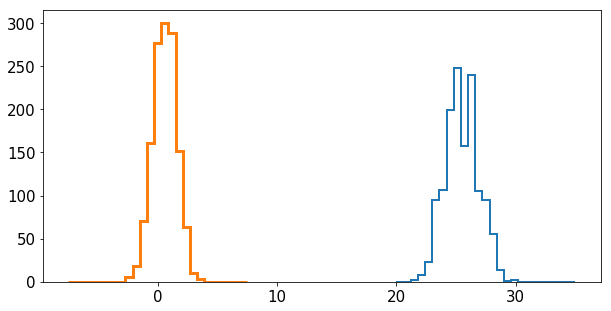

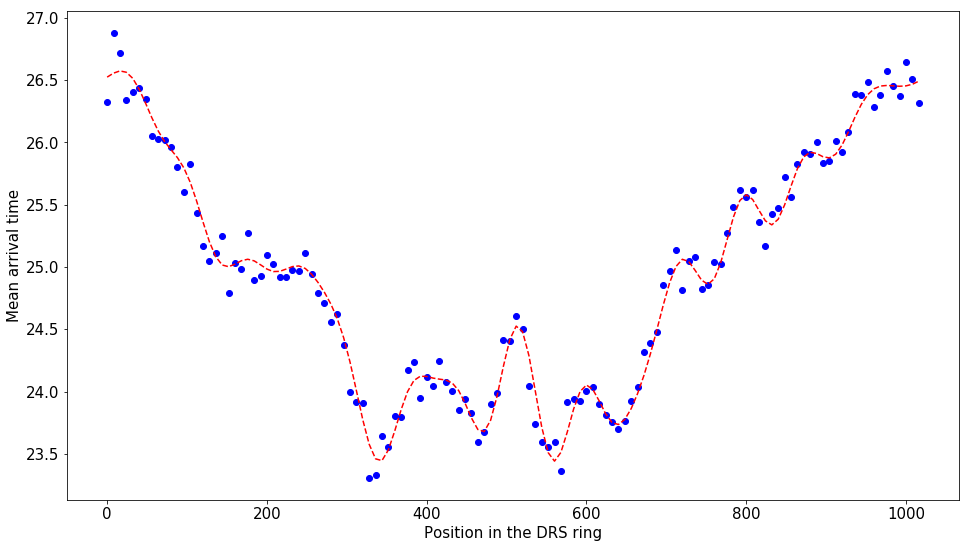

Nr_module = 1, pix = 2
Nr pixel = 1718, std 1 = 1.52, std 2 = 0.98
error = 0.014160702523340351


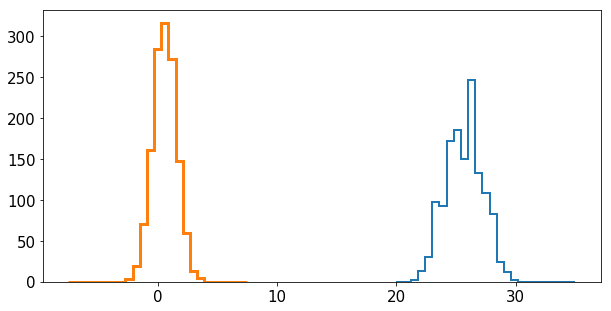

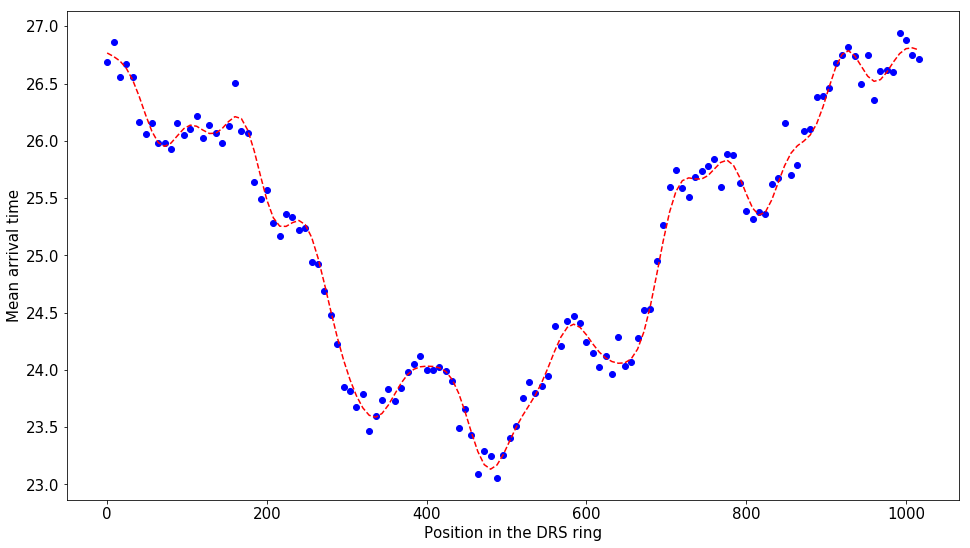

Nr_module = 1, pix = 3
Nr pixel = 1792, std 1 = 1.51, std 2 = 0.97
error = 0.014414387023188528


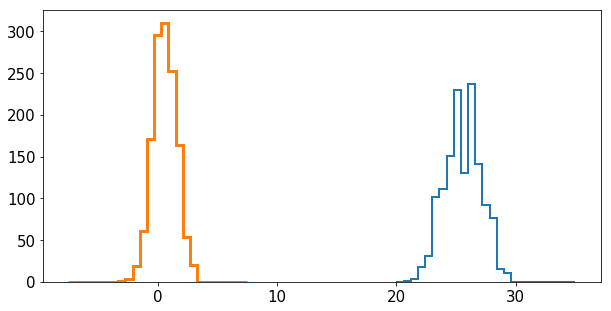

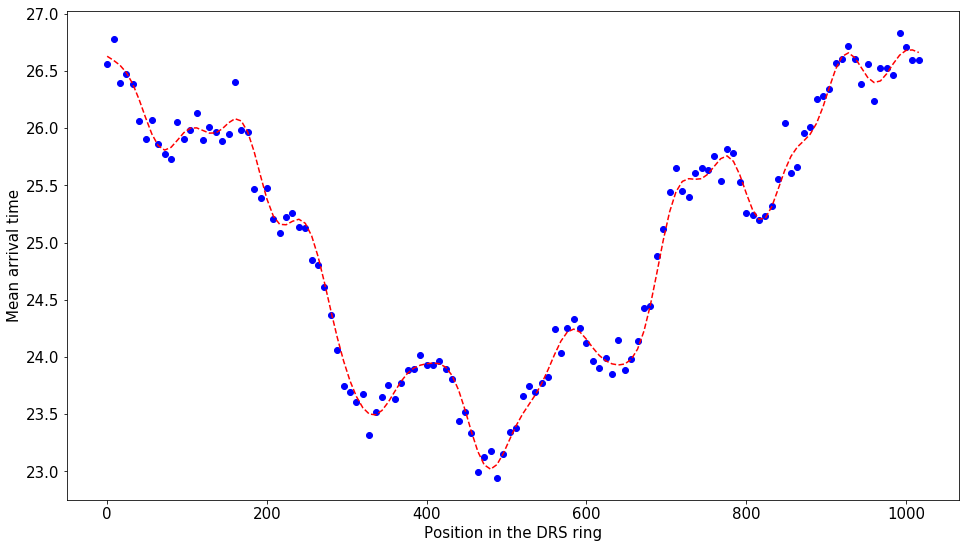

Nr_module = 1, pix = 4
Nr pixel = 1837, std 1 = 1.38, std 2 = 1.13
error = 0.018703622578206312


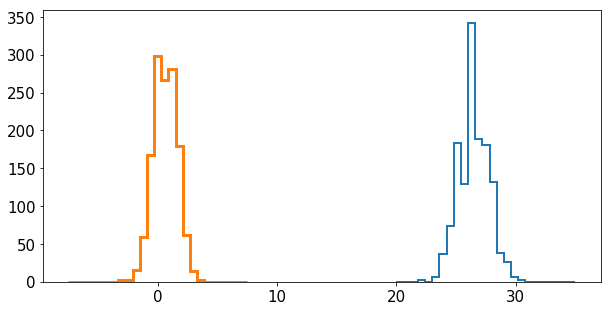

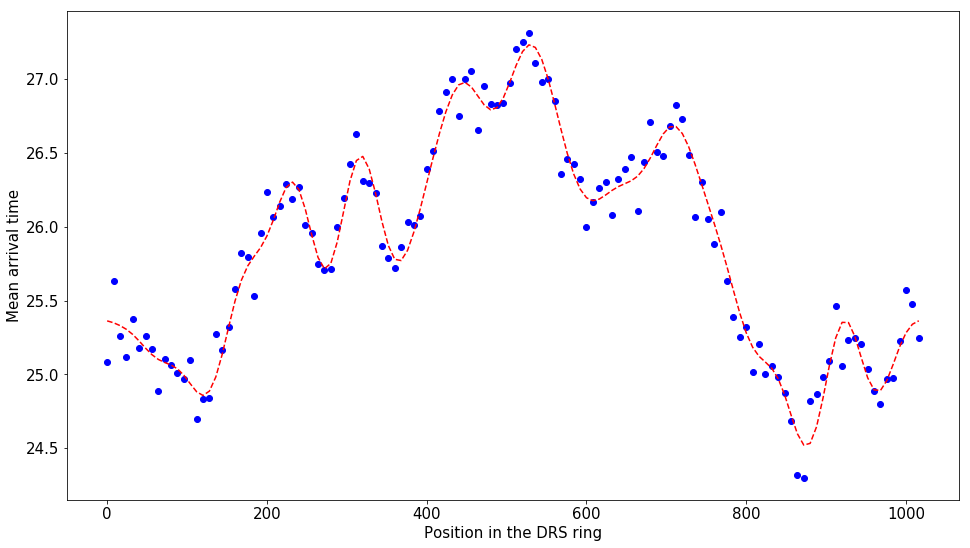

Nr_module = 1, pix = 5
Nr pixel = 1719, std 1 = 1.25, std 2 = 0.98
error = 0.019166045663833564


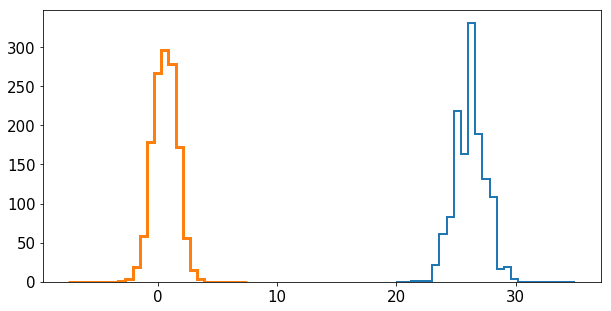

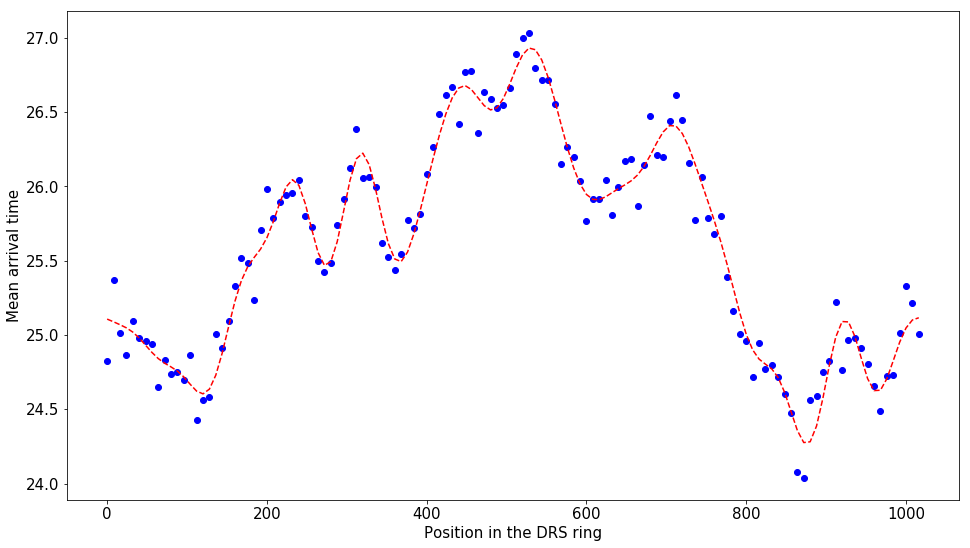

Nr_module = 1, pix = 6
Nr pixel = 1793, std 1 = 1.77, std 2 = 0.98
error = 0.02339706126564226


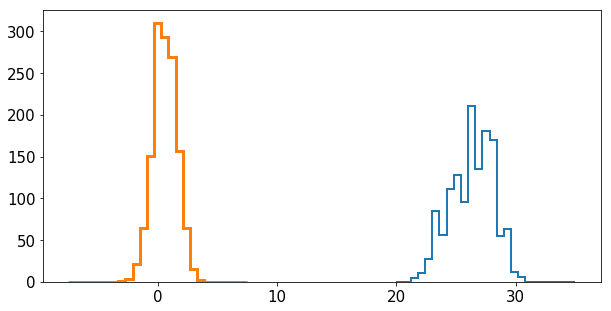

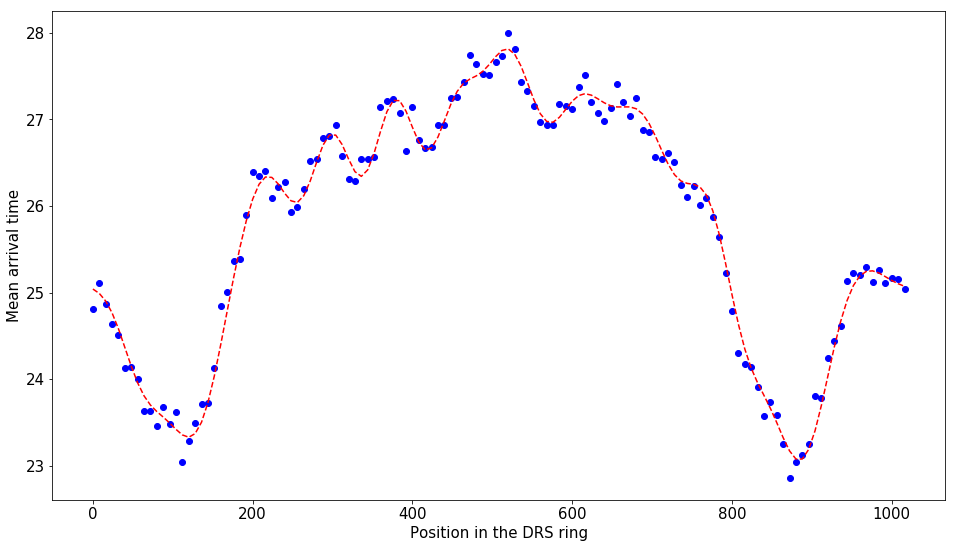

Nr_module = 2, pix = 0
Nr pixel = 1789, std 1 = 1.45, std 2 = 0.96
error = 0.01630526618193715


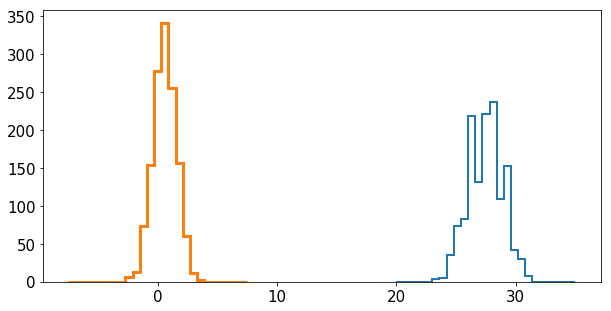

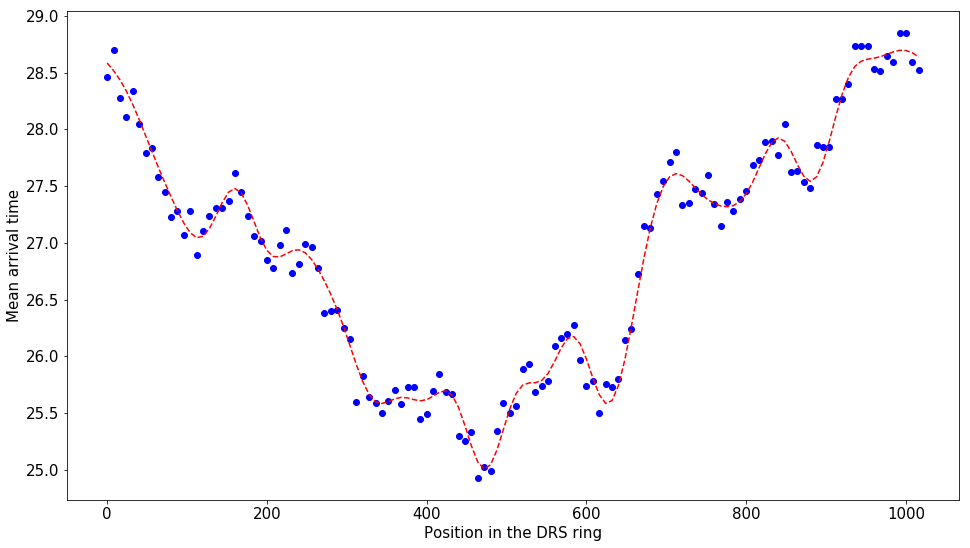

Nr_module = 2, pix = 1
Nr pixel = 1715, std 1 = 1.43, std 2 = 0.96
error = 0.016264804004792584


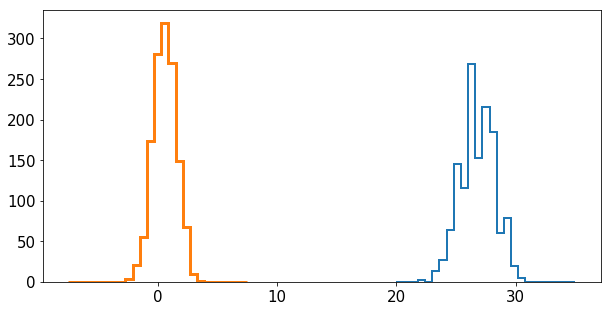

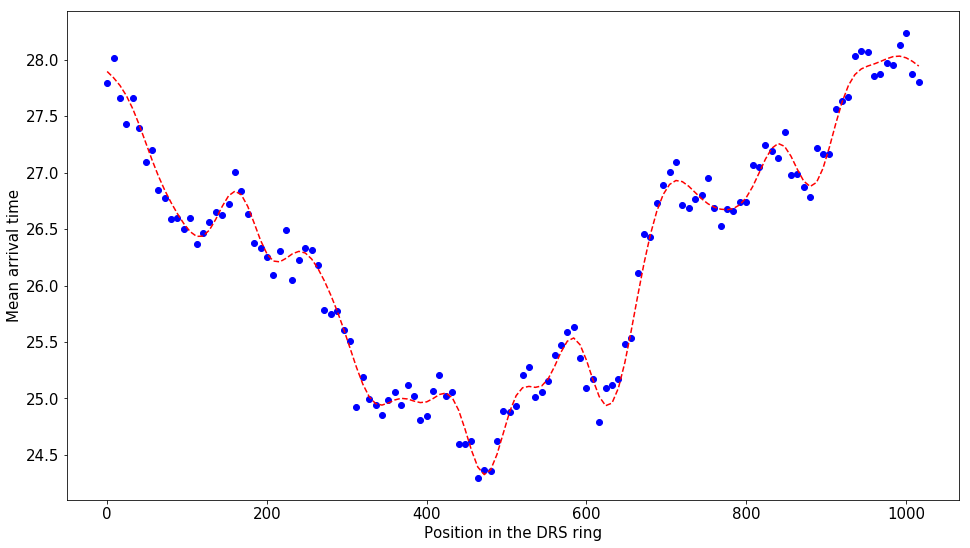

Nr_module = 2, pix = 2
Nr pixel = 1619, std 1 = 1.03, std 2 = 0.98
error = 0.016699558052120866


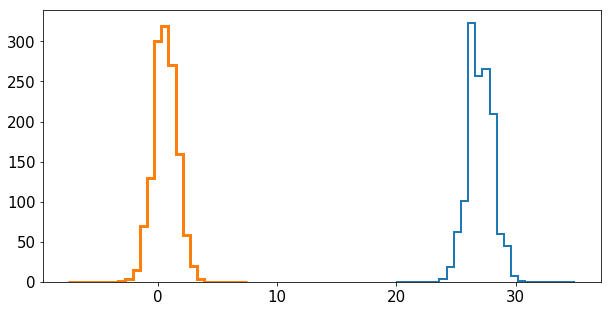

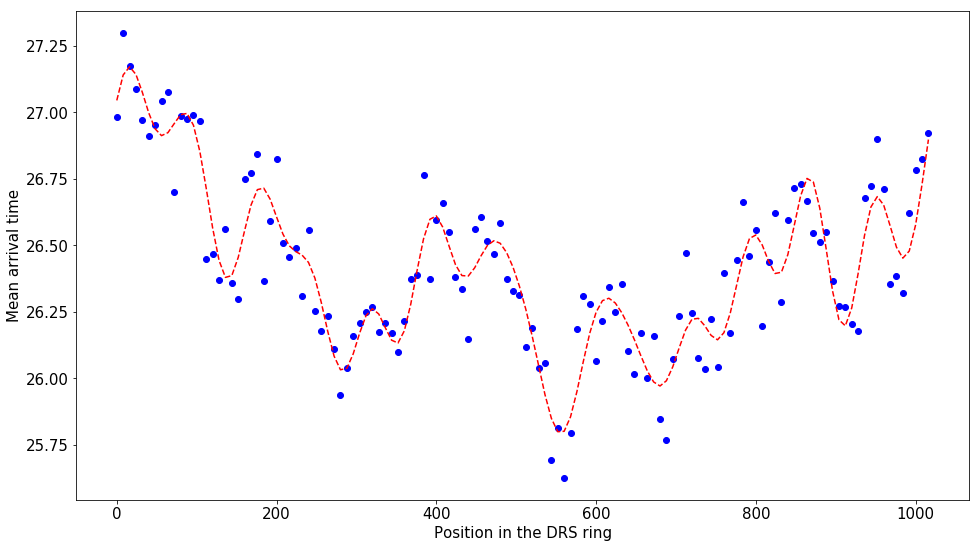

Nr_module = 2, pix = 3
Nr pixel = 1716, std 1 = 1.02, std 2 = 0.98
error = 0.01623822358042107


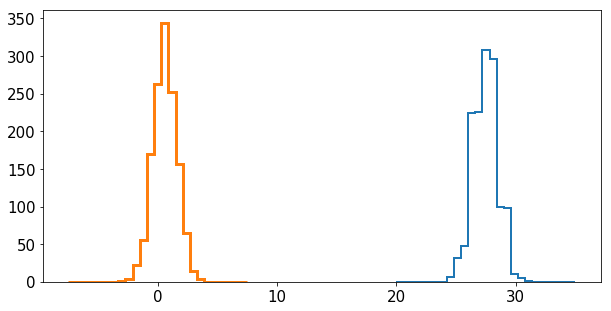

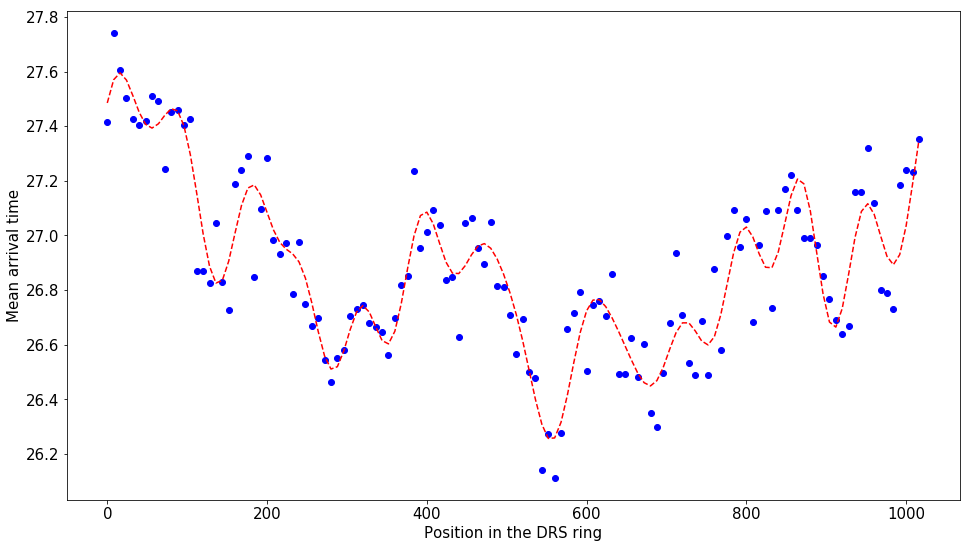

Nr_module = 2, pix = 4
Nr pixel = 1790, std 1 = 1.05, std 2 = 0.98
error = 0.01676288213179537


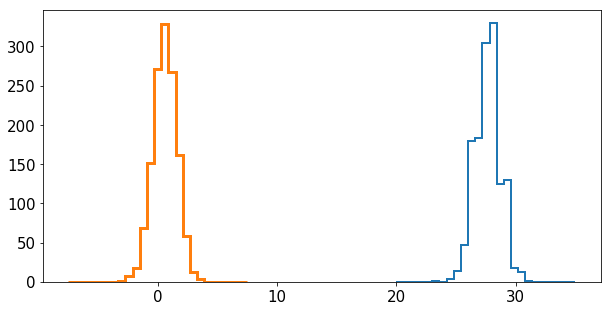

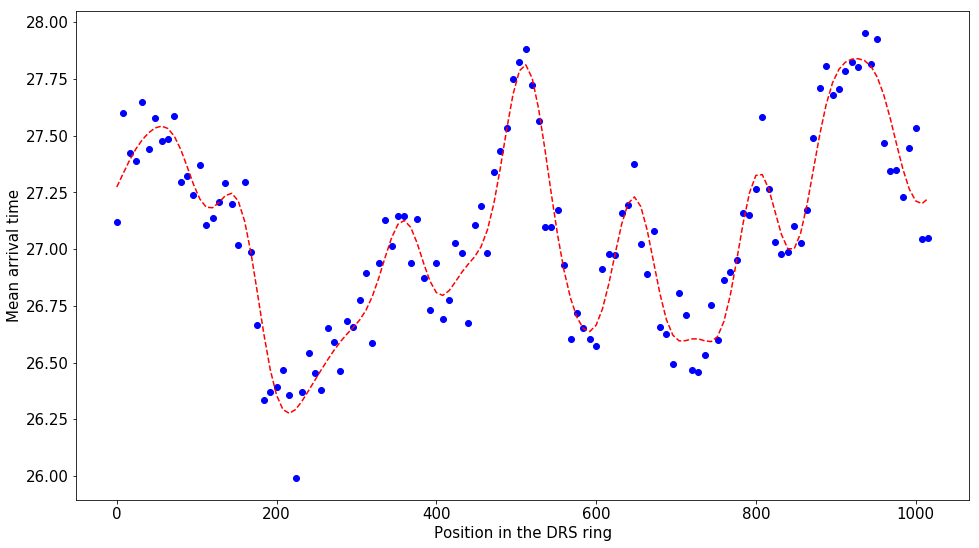

Nr_module = 2, pix = 5
Nr pixel = 1620, std 1 = 1.06, std 2 = 0.98
error = 0.015838056949727237


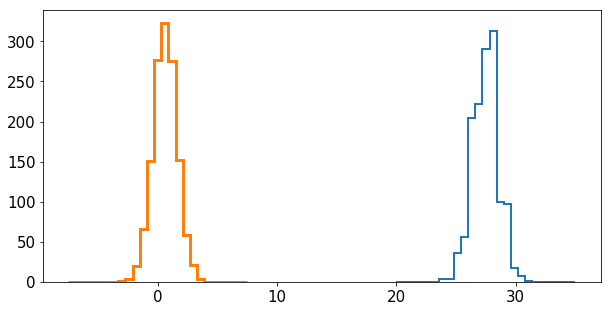

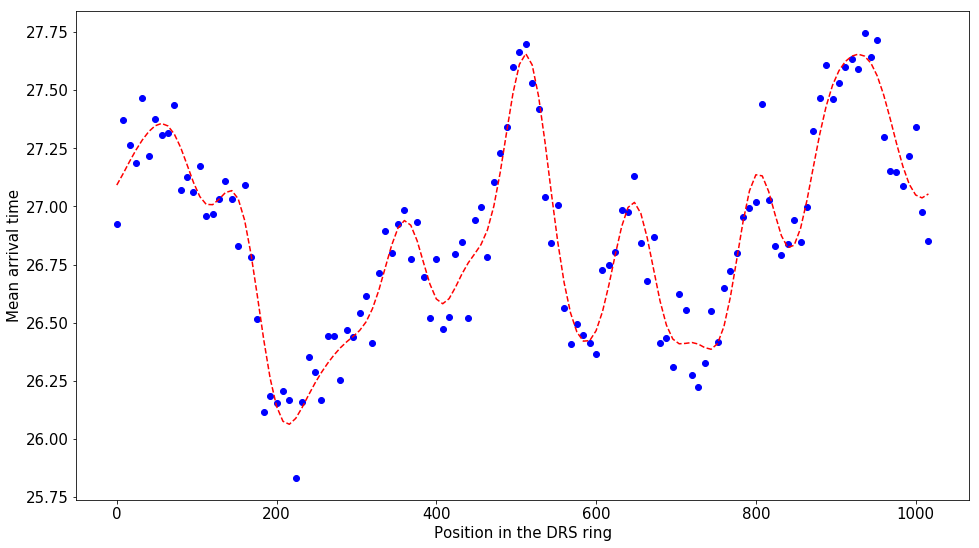

Nr_module = 2, pix = 6
Nr pixel = 1717, std 1 = 1.70, std 2 = 0.98
error = 0.015998714915599795


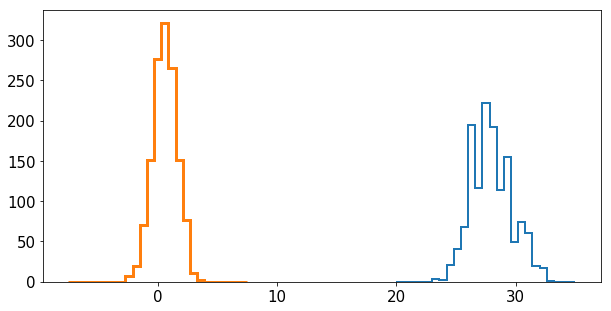

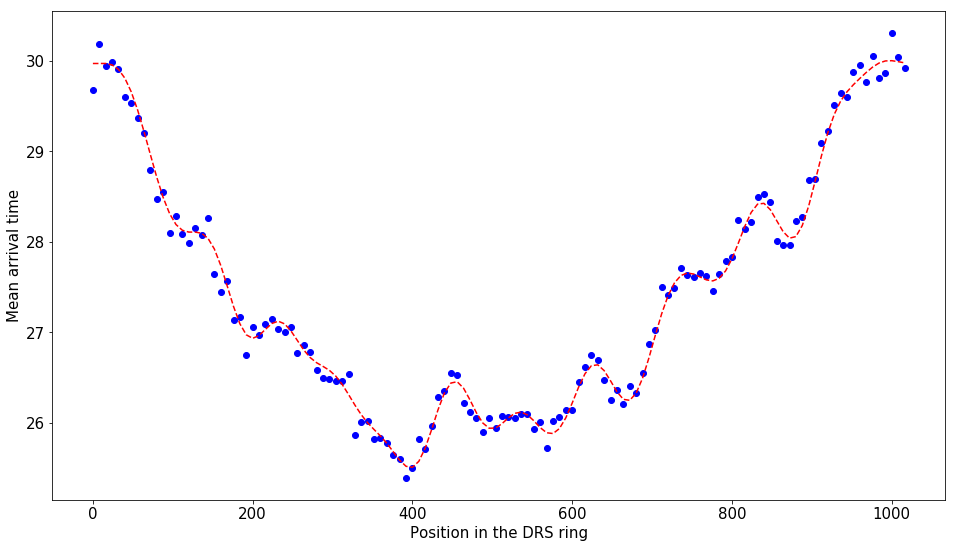

Nr_module = 3, pix = 0
Nr pixel = 1713, std 1 = 0.99, std 2 = 0.97
error = 0.015475515219268552


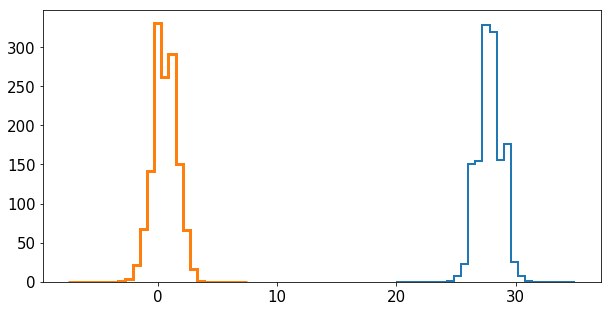

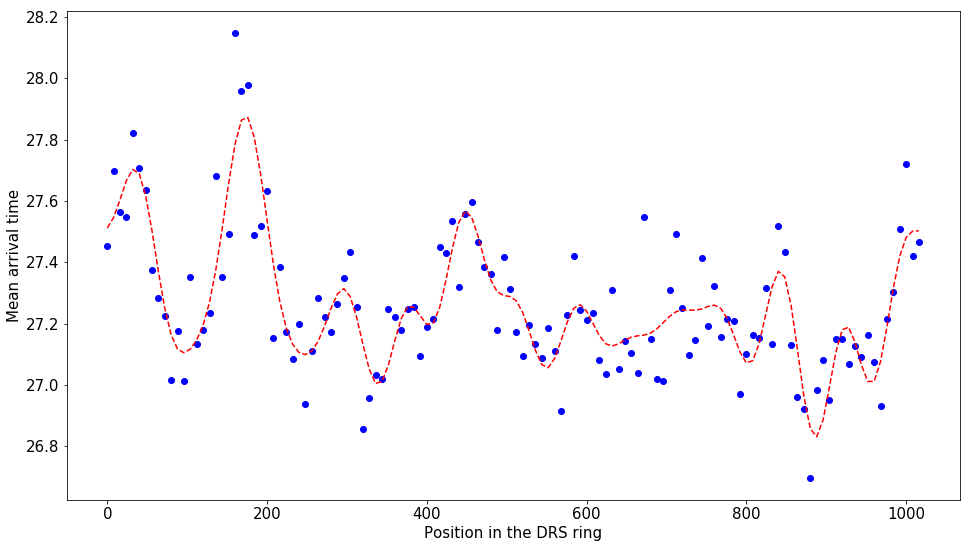

Nr_module = 3, pix = 1
Nr pixel = 1616, std 1 = 1.00, std 2 = 0.98
error = 0.014129837748473591


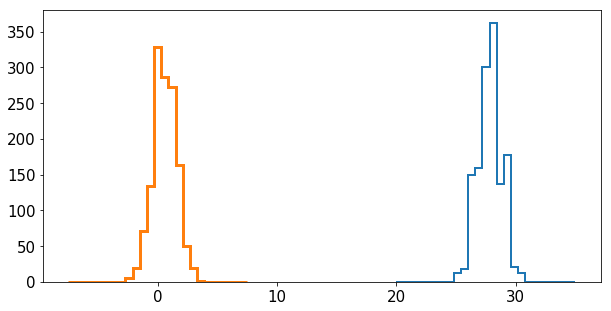

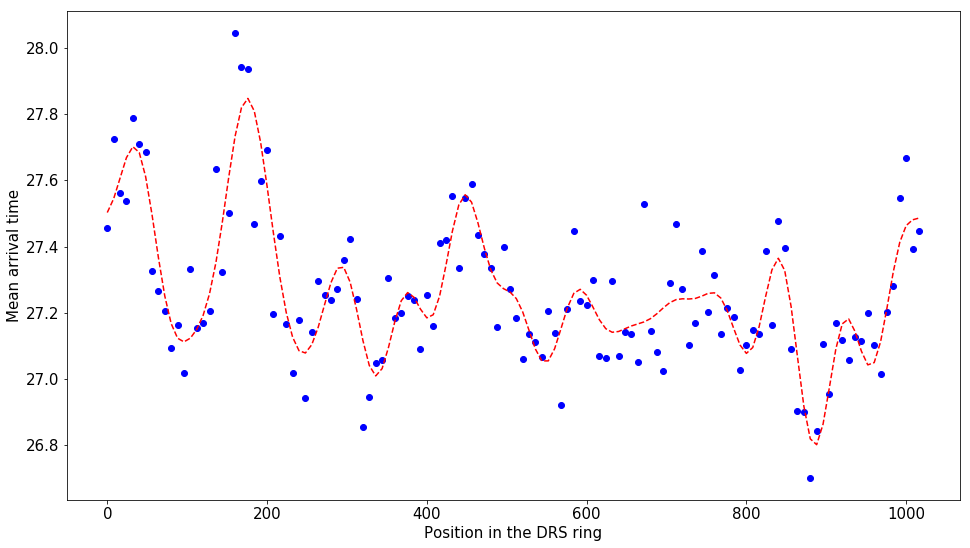

Nr_module = 3, pix = 2
Nr pixel = 1502, std 1 = 1.86, std 2 = 0.97
error = 0.01920914804970663


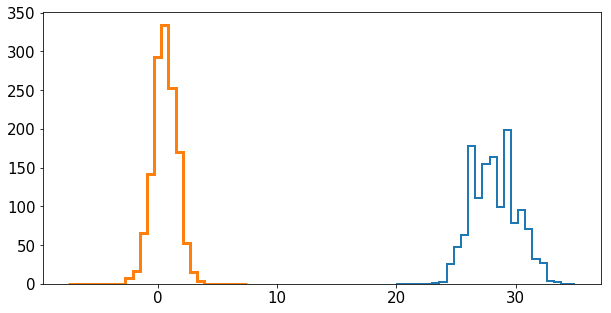

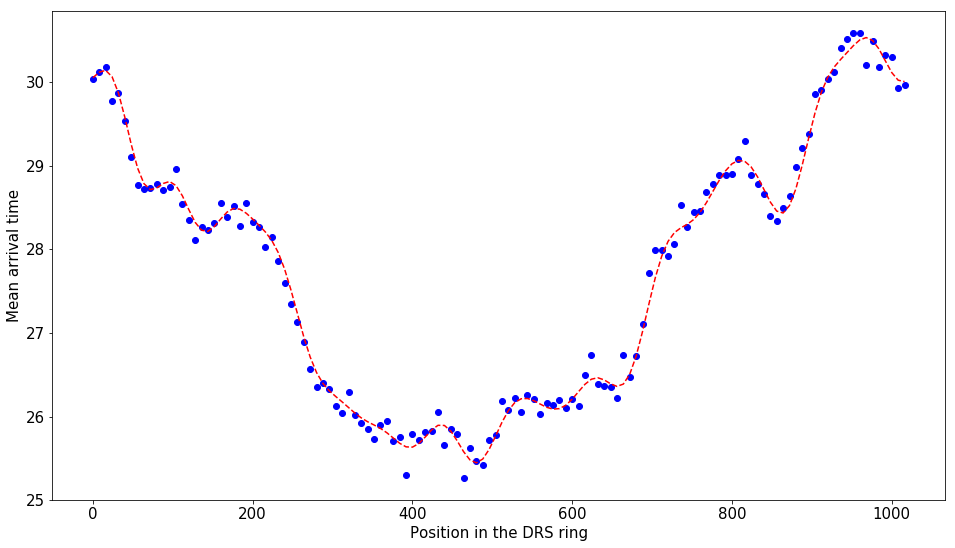

Nr_module = 3, pix = 3
Nr pixel = 1617, std 1 = 1.87, std 2 = 1.07
error = 0.019507757734777385


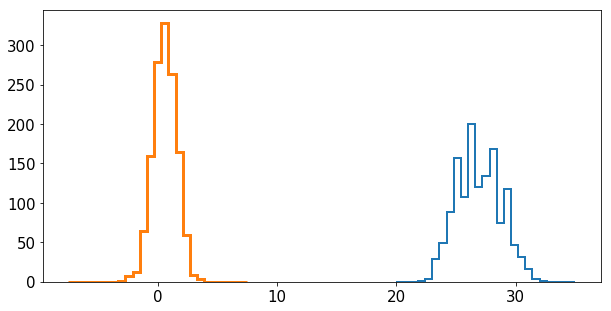

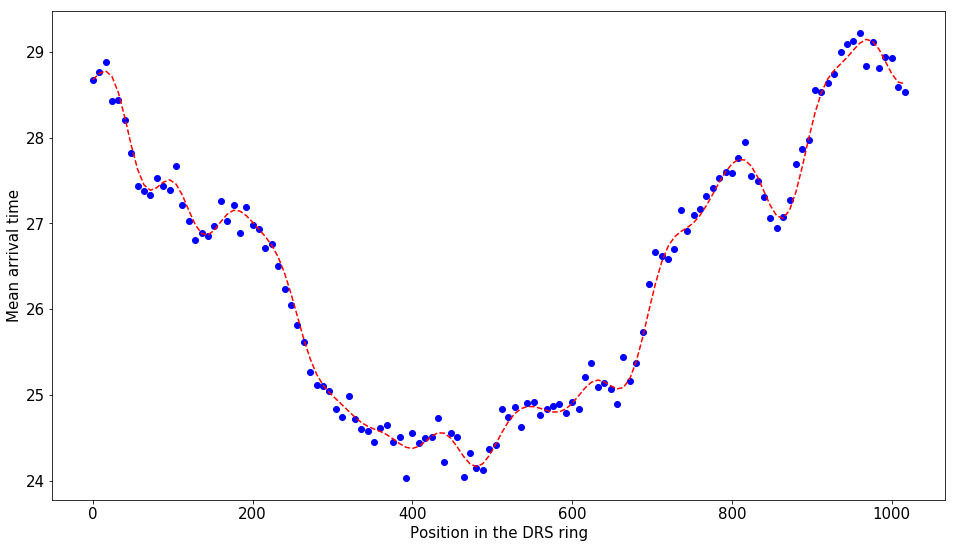

Nr_module = 3, pix = 4
Nr pixel = 1714, std 1 = 1.03, std 2 = 0.96
error = 0.017241592818932908


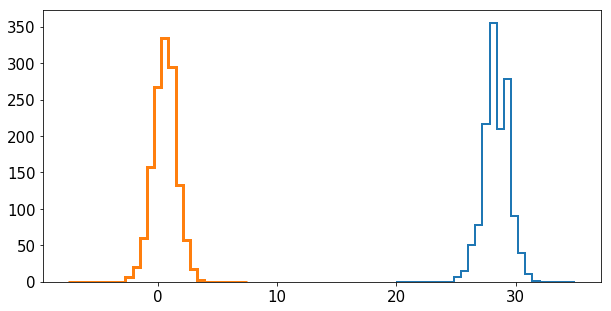

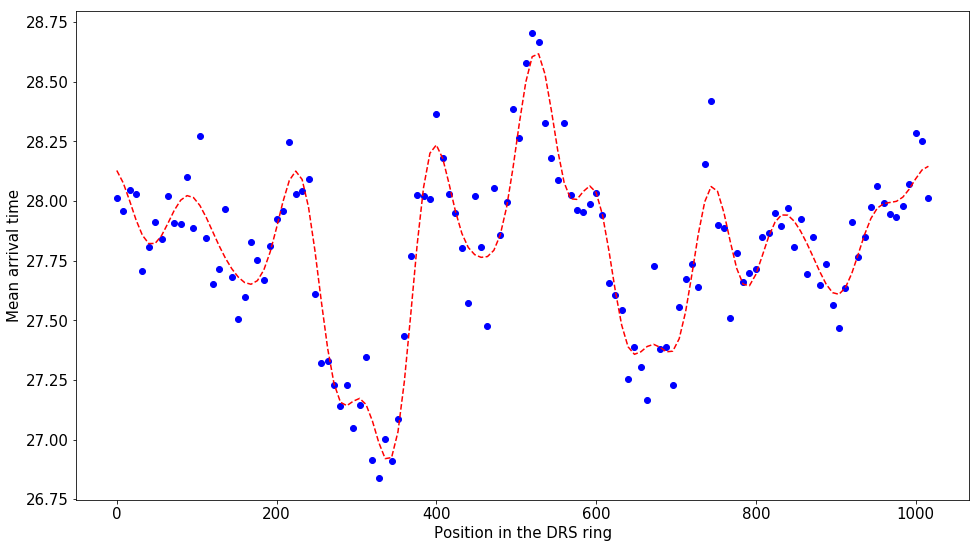

Nr_module = 3, pix = 5
Nr pixel = 1503, std 1 = 1.04, std 2 = 0.97
error = 0.016647854688996988


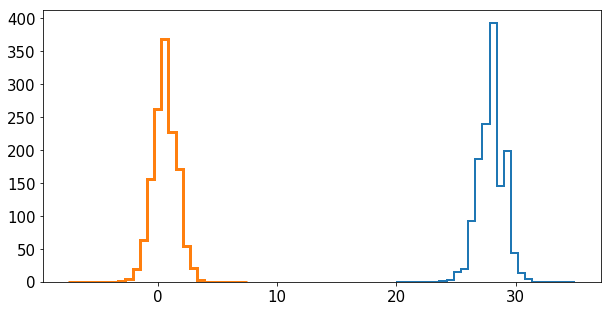

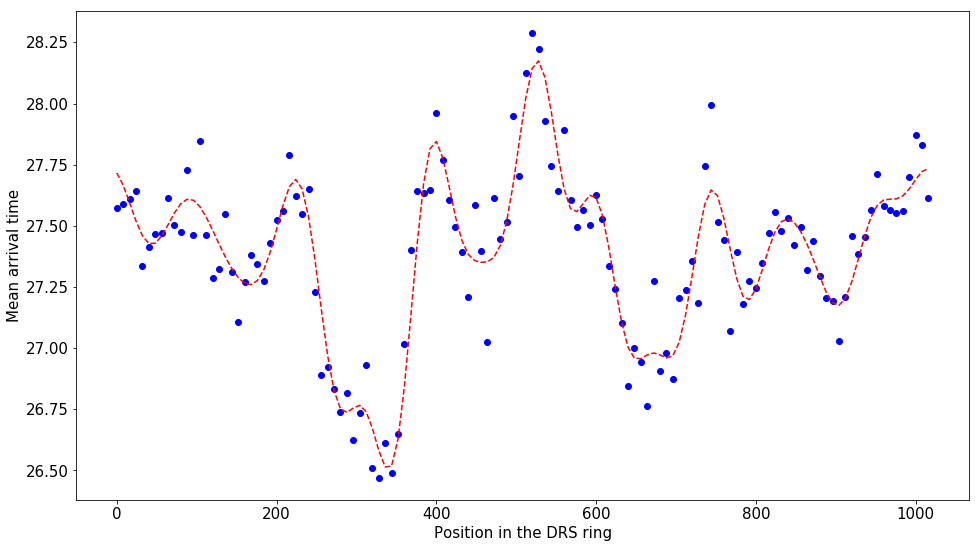

Nr_module = 3, pix = 6
Nr pixel = 1618, std 1 = 1.41, std 2 = 0.98
error = 0.01845608610596889


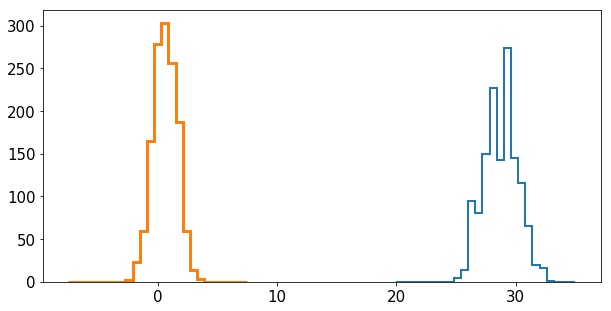

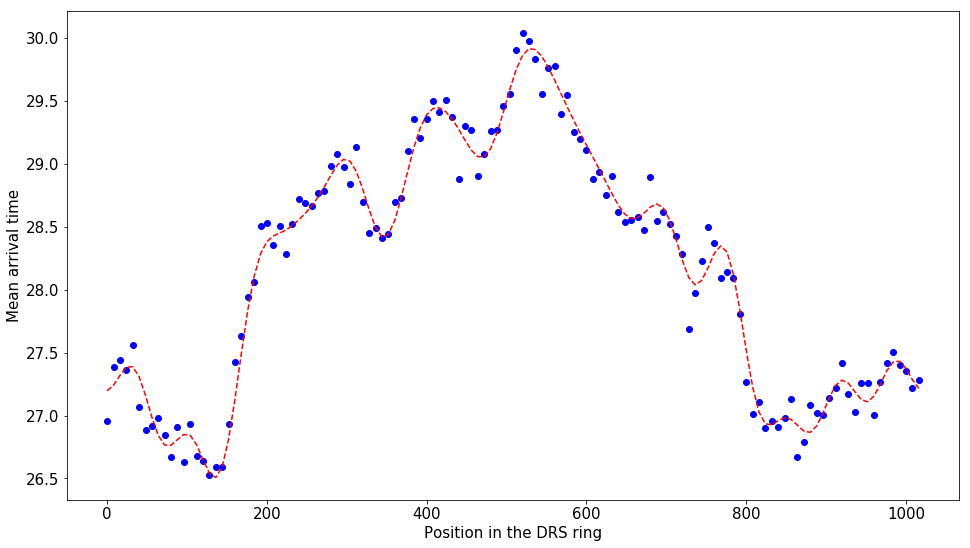

Nr_module = 4, pix = 0
Nr pixel = 1614, std 1 = 1.03, std 2 = 0.95
error = 0.020009984261342623


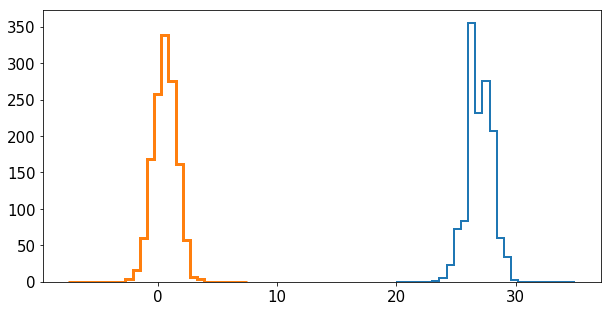

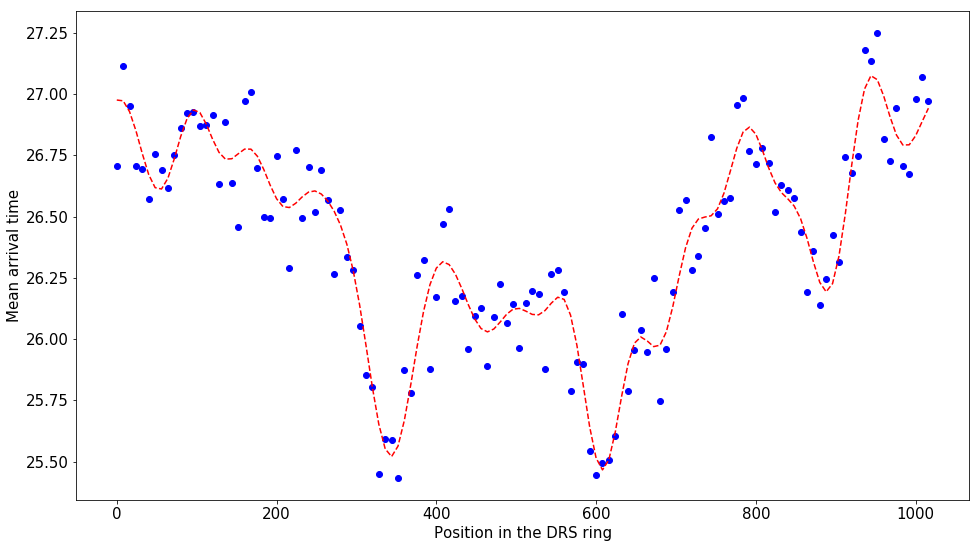

Nr_module = 4, pix = 1
Nr pixel = 1499, std 1 = 1.05, std 2 = 0.97
error = 0.020385215373357343


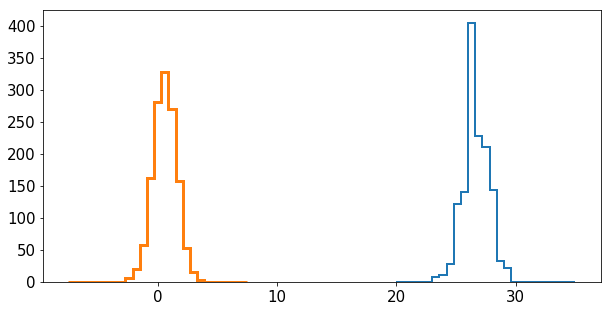

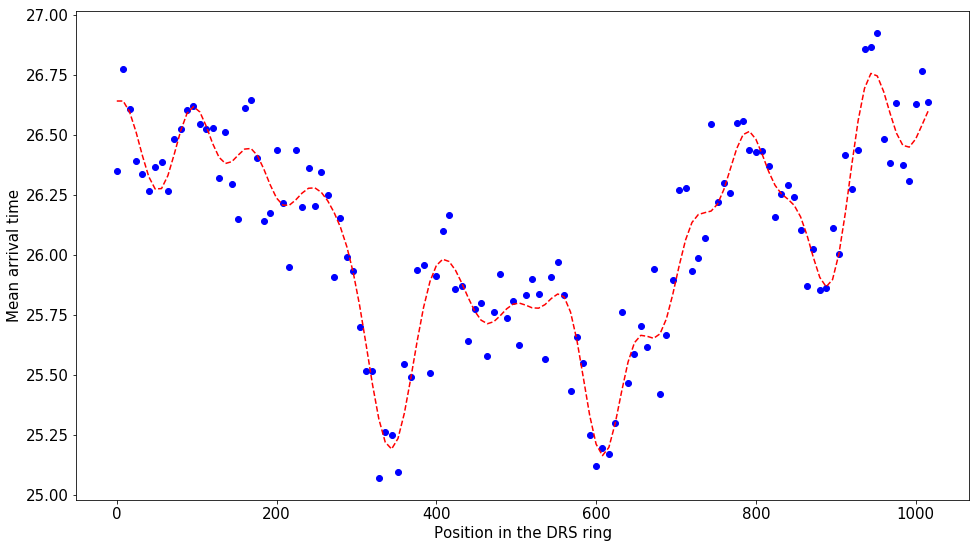

Nr_module = 4, pix = 2
Nr pixel = 1368, std 1 = 1.54, std 2 = 0.98
error = 0.02080439246587214


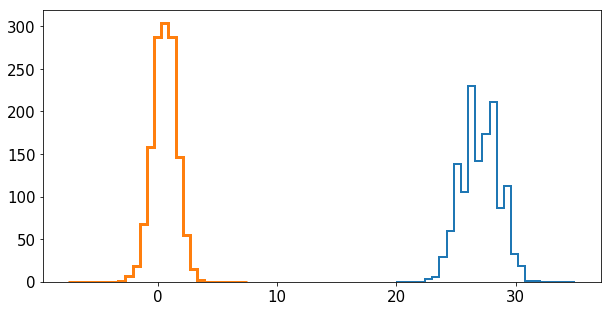

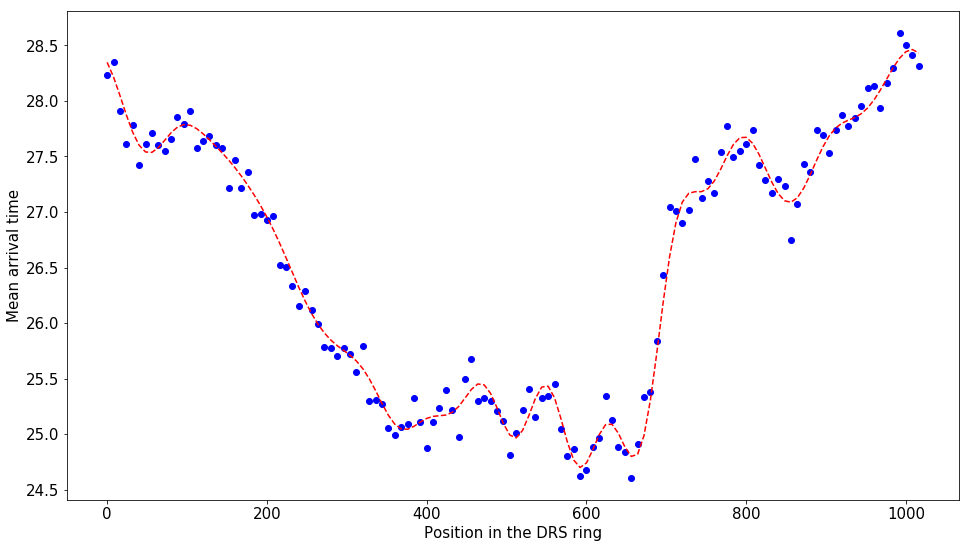

Nr_module = 4, pix = 3
Nr pixel = 1500, std 1 = 1.54, std 2 = 0.98
error = 0.01998852906104505


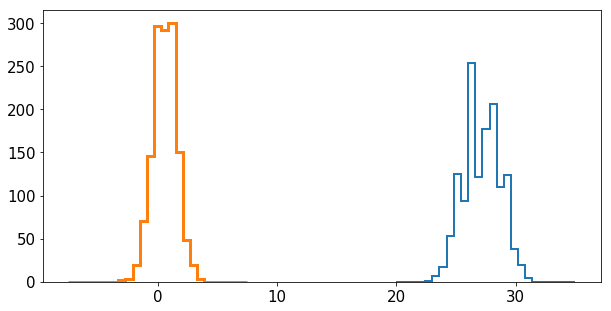

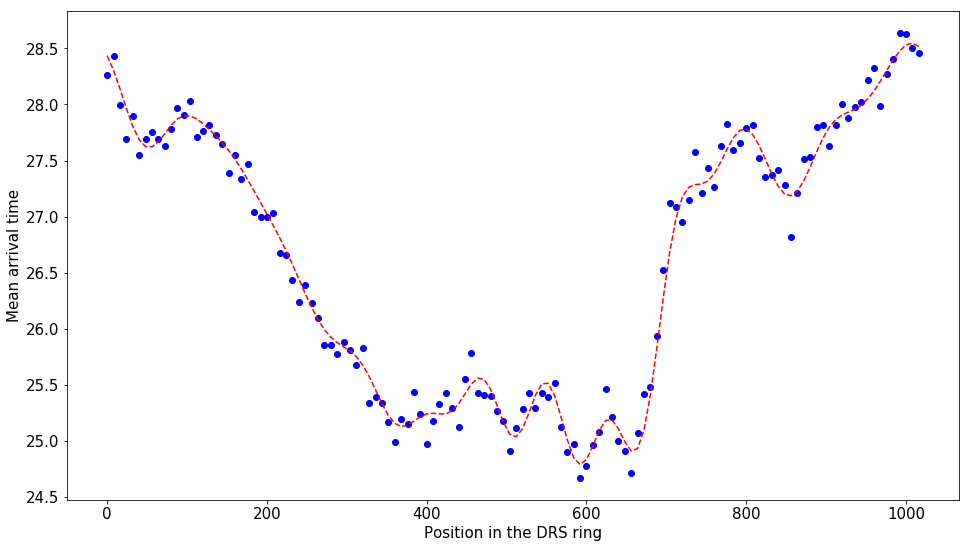

Nr_module = 4, pix = 4
Nr pixel = 1615, std 1 = 1.12, std 2 = 0.97
error = 0.017670908125020136


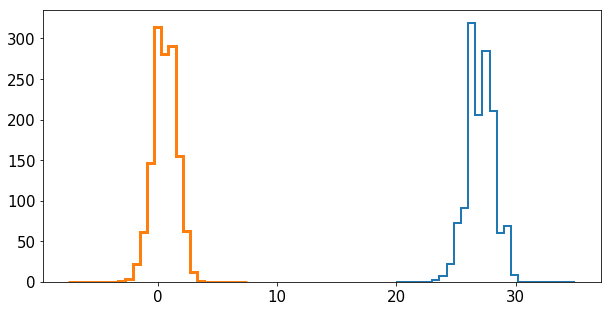

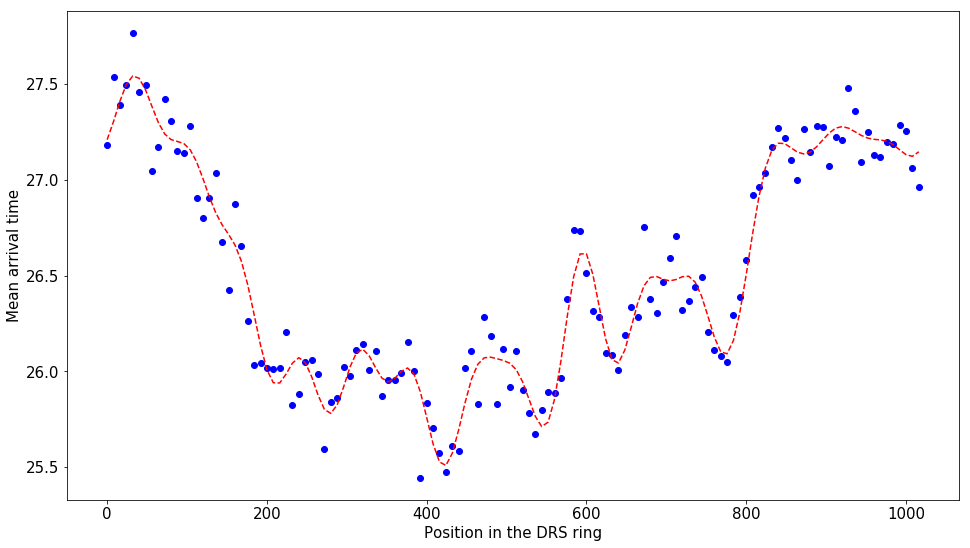

Nr_module = 4, pix = 5
Nr pixel = 1369, std 1 = 1.13, std 2 = 0.97
error = 0.01734558119862125


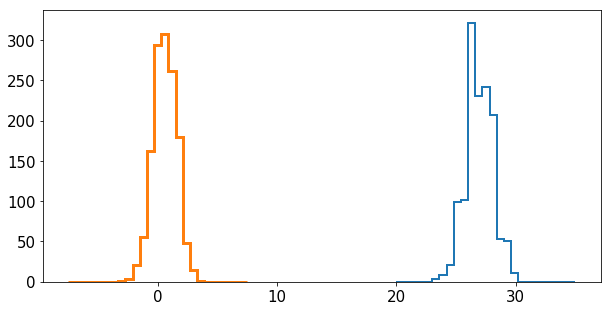

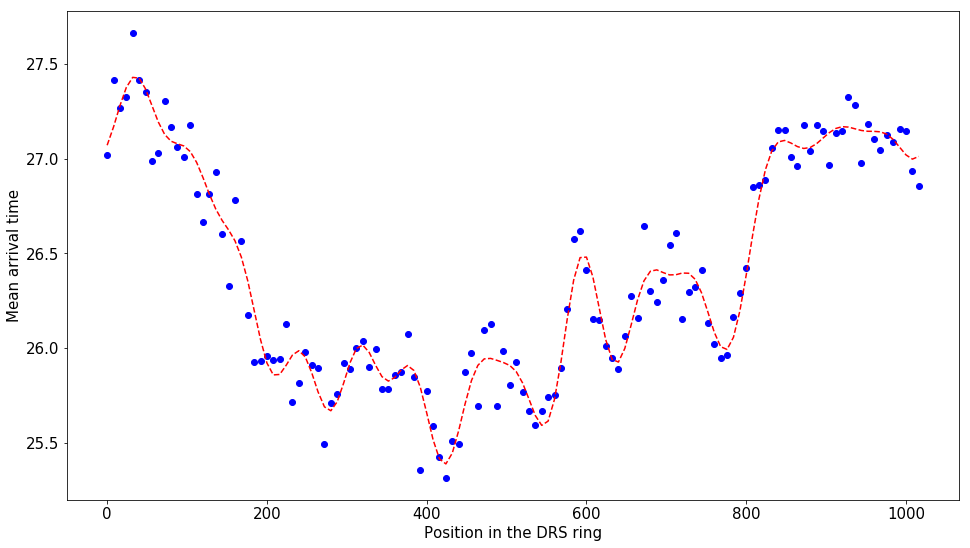

Nr_module = 4, pix = 6
Nr pixel = 1501, std 1 = 1.07, std 2 = 0.96
error = 0.015729389573499078


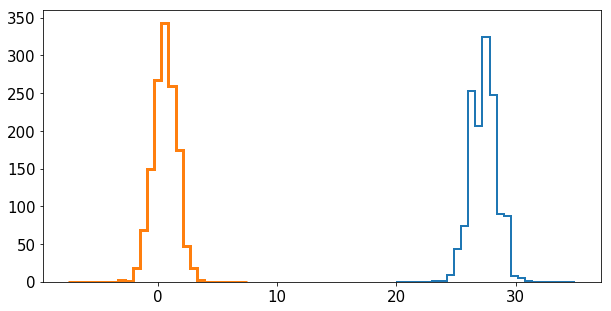

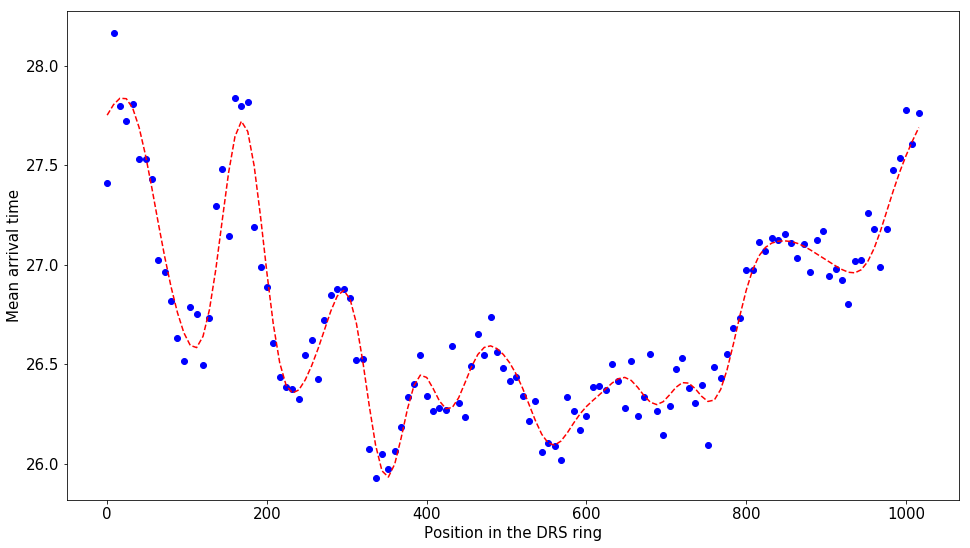

In [20]:
expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
for nr in range(0, 5):
    for pix in range(0, 7):
        pixel_id = expected_pixel_id[nr*7 + pix]
        print("Nr_module = {}, pix = {}".format(nr, pix))
        std_arrival = np.std(arrival_time_list[pixel_id])
        std_corr_arrival = np.std(arrival_time_corr_list[pixel_id])
        print("Nr pixel = {}, std 1 = {:.2f}, std 2 = {:.2f}".format(pixel_id, std_arrival, std_corr_arrival))
        
        plt.figure(figsize=(10, 5))
        plt.hist(arrival_time_list[pixel_id], range=(20, 35) , bins=25, histtype='step', lw=2)
        plt.hist(arrival_time_corr_list[pixel_id],range=(-7.5, 7.5), bins=25, histtype='step', lw=3)
    
        fMeanVal = timeCorr.fMeanVal[pixel_id]
        plot_corr_curve(n, n_cap, n_combine, fan_array[pixel_id], fbn_array[pixel_id], fMeanVal)
        plt.show()

In [40]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax)
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(std_after_corr)
disp0.add_colorbar(ax=ax, label="sygnał [zliczenia ADC]")

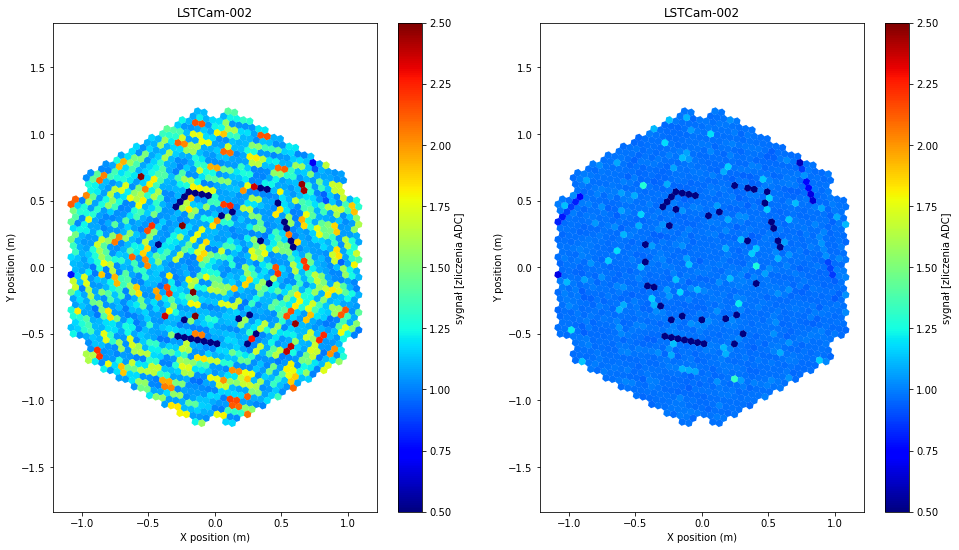

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax[0])
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(std_before_corr)
disp0.add_colorbar(ax=ax[0], label="sygnał [zliczenia ADC]")
disp0.set_limits_minmax(0.5, 2.5)    
        
disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax[1])
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(std_after_corr)
disp0.add_colorbar(ax=ax[1], label="sygnał [zliczenia ADC]")
disp0.set_limits_minmax(0.5, 2.5)

In [ ]:
#input_file_2 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00171.0001.fits.fz"
input_file_2 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00251.0000.fits.fz"
N_events = 3000
reader = LSTEventSource(input_url=input_file_2, max_events=N_events)

lst_r0 = LSTR0Corrections(config=config_corr)
extractor = LocalPeakWindowSum()

mean_time_list = []
dt_list = [[] for i in range(1855)]

for i, ev in enumerate(reader):
    print(i)
    lst_r0.calibrate(ev)
    
    
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380
    try:
        charge, _ = extractor(baseline_subtracted)
        pulse_time =  extract_pulse_time(baseline_subtracted[0, :, :])
        for nr in prange(0, 265):
            fc = get_first_capacitor(ev, nr)
            for pix in prange(0, 7):
                pixel = expected_pixel_id[nr*7 + pix]
            
                if charge[0, pixel] > 1500:
                    corr_pos = get_corr_time(fc[0, pix]%1024, fan_array[pixel], fbn_array[pixel],
                                                        fNumHarmonics=n_harm)
                    corr_time = pulse_time[pixel] - corr_pos + get_mean_time(fan_array[pixel])
    
                    mean_time = np.mean(pulse_time[np.where(charge[0, :] > 1500)])
                    dt = corr_time - mean_time
                    dt_list[pixel].append(dt)
        mean_time_list.append(mean_time)
    except Exception as err:
        pass

In [ ]:
plt.figure(figsize=(16, 9))
plt.hist(mean_time_list, bins=25, range=(20, 30), histtype='step',lw=5)

In [ ]:
plt.figure(figsize=(16, 9))
for nr in range(4, 5):
    for pix in range(0, 1):
        pixel = expected_pixel_id[nr*7 + pix]
        plt.hist(dt_list[pixel], histtype='step',lw=5, range=(-5, 2), bins=50)

In [ ]:
mean_dt_arrival_time = []
for i in range(0 , 1855):
    mean_dt_arrival_time.append(np.nanmean(dt_list[i]))

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

disp0 = CameraDisplay(ev.inst.subarray.tels[0].camera, ax=ax)
disp0.cmap = 'jet'
disp0.image = np.nan_to_num(mean_dt_arrival_time)
disp0.add_colorbar(ax=ax, label="Arrival time diffrence")

In [ ]:
np.where(fan_array == NaN)

In [ ]:
np.argwhere(np.isnan(fan_array))

In [ ]:
fan_array[1802]

In [ ]:
fan_array

In [6]:
import h5py

In [9]:


try:
    hf = h5py.File('coeff.h5', 'w')
    hf.create_dataset('fan', data=fan_array)
    hf.create_dataset('fbn', data=fbn_array)
except Exception as err:
    print("FAILED!", err)

hf.close()


In [ ]:
hf.close()

In [ ]:
hf = h5py.File('coeff.h5', 'r')

In [ ]:
hf.keys()

In [ ]:
fan = hf.get('fan')

In [ ]:
fan

In [ ]:
fan = np.array(fan)

In [ ]:
fan